## 4.1 实现 LLM 的架构

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 100277,    # Vocabulary size (from BPE tokenizer)
    "context_length": 1024, # Context length( how many token can model handle)
    "emb_dim": 768,         # Embedding dimension (each token transfer to 768 dims)
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers(how many transofmrer layer do we need)
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [2]:
# Listing 4.1 A placeholder GPT model architecture class
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])      #A
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])                       #B
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):                                       #C
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):                                                     #D
        return x

class DummyLayerNorm(nn.Module):                                              #E
    def __init__(self, normalized_shape, eps=1e-5):                           #F
        super().__init__()

    def forward(self, x):
        return x


#A 为 TransformerBlock 设置占位符
#B 为 LayerNorm 设置占位符
#C 一个简单的占位类，后续将被真正的 TransformerBlock 替换
#D 该模块无实际操作，仅原样返回输入
#E 一个简单的占位类，后续将被真正的 DummyLayerNorm 替换
#F 此处的参数仅用于模拟LayerNorm接口

In [3]:
import tiktoken

tokenizer = tiktoken.encoding_for_model("gpt-4")
tokenizer.n_vocab

100277

In [4]:
batch = []

txt1 = "heelodasd"
txt2 = " nihao"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim=0)
batch

tensor([[ 8597,   347, 80202],
        [  308,  7141,  3524]])

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
logits,logits.shape
# 每个token被转换成了vocab size的维度

(tensor([[[ 0.7294, -0.9918, -0.5595,  ..., -0.4872,  0.2833,  0.1160],
          [ 0.4177,  1.9711, -0.3894,  ...,  1.3055,  1.0193,  0.0973],
          [-0.9279, -0.1050, -0.3882,  ..., -1.4838,  0.0462,  0.1469]],
 
         [[-0.0077, -1.1776, -0.3267,  ..., -0.2297, -0.1586,  1.2162],
          [ 0.4273,  1.4703,  1.4208,  ...,  0.3123, -0.6263, -0.3699],
          [-1.5987, -0.7349,  0.4377,  ..., -1.4158,  1.7225,  1.9415]]],
        grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 3, 100277]))

## 4.2 使用层归一化对激活值进行标准化

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
out,out.shape

(tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
         [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
        grad_fn=<ReluBackward0>),
 torch.Size([2, 6]))

In [7]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
mean,mean.shape,var,var.shape

(tensor([[0.1324],
         [0.2170]], grad_fn=<MeanBackward1>),
 torch.Size([2, 1]),
 tensor([[0.0231],
         [0.0398]], grad_fn=<VarBackward0>),
 torch.Size([2, 1]))

在计算均值或方差等操作时使用 keepdim=True 参数，可以确保输出张量的维度与输入张量相同，即使该操作通过dim参数减少了张量的维度。例如，如果不使用 keepdim=True，返回的均值张量将是一个二维向量 [0.1324, 0.2170]，而使用 keepdim=True 后，返回的张量则会是一个 2×1 的矩阵 [[0.1324], [0.2170]]。

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
torch.set_printoptions(sci_mode=False)
# 关闭科学计数法
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        mean_x = (x-mean) / torch.sqrt(var + self.eps)
        y = self.scale * mean_x + self.shift
        return y
# 变量 eps 是一个小常数（epsilon），在归一化过程中加到方差上，
# 以防止出现除零错误。scale 和 shift 是两个可训练参数（与输入具有相同的维度）

`unbiased=False` 是 `torch.var` 函数的一个参数，控制方差的计算方式：
* **当 `unbiased=True`（默认）**，方差是无偏估计，会除以 $N-1$（样本数减1）。
* **当 `unbiased=False`**，方差是有偏估计，会除以 $N$（样本数）。
* **无偏（unbiased=True）**:
  $\text{Var} = \frac{1}{N-1} \sum_{i=1}^N (x_i - \bar{x})^2$
* **有偏（unbiased=False）**:
  $\text{Var} = \frac{1}{N} \sum_{i=1}^N (x_i - \bar{x})^2$

**为什么 LayerNorm 用 unbiased=False？**
LayerNorm 是对每个样本自己的特征做归一化（不是整批），用有偏估计（除以N）与标准实现一致，数值更稳定，也和 numpy 的 `var` 行为一致（默认除以N）。



In [11]:
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 4.3 实现带有 GELU 激活函数的前馈神经网络

In [13]:
# Listing 4.3 An implementation of the GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

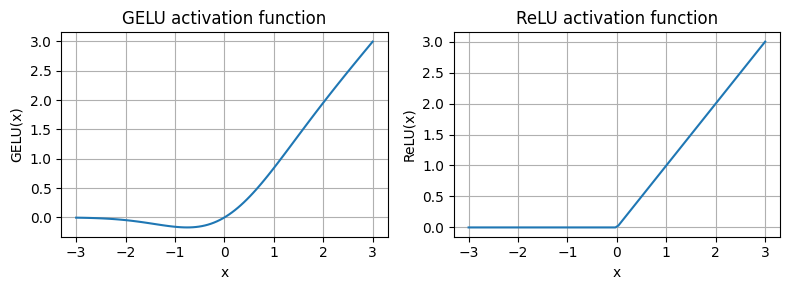

In [14]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)                                          #A
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

#A 在 -3 到 3 的范围内生成 100 个样本数据点

ReLU 是一个分段线性函数，输入为正时输出输入值本身，否则输出零。而 GELU 是一种平滑的非线性函数，它近似于 ReLU，但在负值上也具有非零梯度。

GELU 的平滑性使其在训练过程中具有更好的优化特性，能够对模型参数进行更细微的调整。相比之下，ReLU 在零点处有一个拐角，这在网络深度较大或结构复杂时可能会增加优化难度。此外，ReLU 对所有负输入的输出为零，而 GELU 对负值允许一个小的非零输出。这意味着在训练过程中，接收负输入的神经元也能对学习过程产生一定的贡献，尽管贡献程度不及正输入

In [15]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
        )

    def forward(self,x):
        return self.layers(x)

In [16]:
ffn = FeedForward(GPT_CONFIG_124M)

x = torch.randn(2,3,768)
y = ffn(x)
y,y.shape

(tensor([[[-0.3731, -0.2161,  0.1972,  ..., -0.2462,  0.0535,  0.2413],
          [ 0.0069,  0.0609,  0.3952,  ...,  0.1626, -0.0415, -0.1237],
          [ 0.1569, -0.1565, -0.0789,  ..., -0.3007,  0.2389, -0.1702]],
 
         [[ 0.2887,  0.0783,  0.1038,  ..., -0.2605, -0.0504, -0.2268],
          [-0.0889,  0.2274,  0.0563,  ..., -0.2062,  0.0148, -0.2420],
          [ 0.2520, -0.0005, -0.2848,  ..., -0.0739, -0.0354,  0.0410]]],
        grad_fn=<ViewBackward0>),
 torch.Size([2, 3, 768]))

In [17]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            # Implement 5 layers
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self,x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                # 需要保证维度一致才能使用残差链接
                x = layer_output + x
            else:
                x = layer_output
        return x

In [18]:
layers_size = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layers_size,use_shortcut=False
)
sample_input.shape

torch.Size([1, 3])

In [19]:
def print_gradients(model,x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    l = loss(output,target)
    l.backward()

    for name,param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


当调用 loss.backward() 时，PyTorch 会为模型的每一层计算损失的梯度。我们可以通过 model.named_parameters() 遍历权重参数

In [20]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152042235247791
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


In [21]:
model_with_shotcut = ExampleDeepNeuralNetwork(
    layers_size,use_shortcut=True
)

print_gradients(model_with_shotcut,sample_input)

layers.0.0.weight has gradient mean of 0.0014432318275794387
layers.1.0.weight has gradient mean of 0.004846962168812752
layers.2.0.weight has gradient mean of 0.004138901364058256
layers.3.0.weight has gradient mean of 0.005915128160268068
layers.4.0.weight has gradient mean of 0.03265950828790665


从输出结果可以看到，最后一层（layers.4）的梯度依然比其他层更大。然而，随着接近第一层（layers.0），梯度值逐渐趋于稳定，并未缩小到几乎消失的程度。

能够很好的缓解当神经网络深度很深的时候，梯度消失的情况

In [22]:
# file: multi_head_attention.py
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, max_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.queries = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.keys = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.values = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask",
            torch.triu(torch.ones(max_length, max_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, d_in = x.shape
        assert num_tokens <= self.mask.shape[0], "num_tokens exceeds max_length"

        queries = self.queries(x).view(batch_size, num_tokens, self.num_heads, self.head_dim)
        keys = self.keys(x).view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values = self.values(x).view(batch_size, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2)  # (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = torch.matmul(queries, keys.transpose(-2, -1))  # (batch, num_heads, num_tokens, num_tokens)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0)
        attn_scores = attn_scores.masked_fill(mask_bool, float('-inf'))

        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vecs = torch.matmul(attn_weights, values)  # (batch, num_heads, num_tokens, head_dim)
        context_vecs = context_vecs.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)
        context_vecs = self.proj(context_vecs)
        return context_vecs


In [23]:
import torch

x = torch.tensor([1, 2, 3])      # shape: [3]
y = x.unsqueeze(0)               # shape: [1, 3]
z = x.unsqueeze(1)               # shape: [3, 1]
# 因为x是一维的，所以y就是在一维前加一维，变成1，3 
# z是在一维后面再加一维，变成3，1
print(x.shape)  # torch.Size([3])
print(y.shape)  # torch.Size([1, 3])
print(z.shape)  # torch.Size([3, 1])


torch.Size([3])
torch.Size([1, 3])
torch.Size([3, 1])


In [24]:
class FeedForward(nn.Module):
    def __init__(self,num_dim):
        super().__init__()
        self.layers = nn.ModuleList([#需要传入一个列表
            nn.Sequential(nn.Linear(num_dim,4*num_dim)),
            GELU(),
            nn.Sequential(nn.Linear(4*num_dim,num_dim)),
        ])

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

class LayerNorm(nn.Module):
    def __init__(self,num_dim):
        super().__init__()
        self.eps = 1e-5
        self.register_buffer("scale", torch.ones(num_dim))
        self.register_buffer("shift", torch.zeros(num_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased = False)
        y = (x-mean) - torch.sqrt(var + self.eps)
        return self.scale * y + self.shift

In [25]:
GPT_CONFIG_124M

{'vocab_size': 100277,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [26]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            max_length= cfg["context_length"],
            dropout = cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg["emb_dim"])
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shotcut = nn.Dropout(cfg["drop_rate"])

    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shotcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shotcut(x)
        x = shortcut + x
        return x
# 归一化-- multihead attn --dropout -- resnet -- 归一化 -- ff -- dropout -- resnet

In [27]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)                    #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

#A 建一个形状为 [batch_size, num_tokens, emb_dim] 的输入张量

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


Transformer 模块结构中保持数据形状不变并非偶然，而是其设计的一个关键特性。这种设计使 Transformer 擅长处理各种序列到序列任务，因为每个输出向量直接对应一个输入向量，保持一一对应关系。然而，虽然维度一致，但输出向量是包含整个输入序列信息的“上下文向量”。也就是说，尽管序列的物理维度（长度和特征维度）在经过 Transformer 模块时保持不变，但每个输出向量的内容会被重新编码，融合整个输入序列的上下文信息。

In [28]:
# Listing 4.7 The GPT model architecture implementation
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        # 将每个token的embdim维度嵌入向量再转换成vocabsize大小的向量，然后计算softmax，选出这个token最有可能是什么？ dim=-1
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))      #A
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

 #A 设备设置将根据输入数据所在的位置选择在 CPU 或 GPU 上训练模型

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[ 8597,   347, 80202],
        [  308,  7141,  3524]])

Output shape: torch.Size([2, 3, 100277])
tensor([[[ 6.9786,  1.9400, 14.0354,  ..., -2.2986,  0.8146, -3.0674],
         [ 4.5567,  0.1219,  7.7915,  ...,  2.6425, -1.1140,  3.0169],
         [ 1.5988,  3.9577,  9.5935,  ..., -4.4785,  1.3988, -7.7583]],

        [[-4.0090,  2.5505,  7.9679,  ..., -2.8691, -6.3033, -6.7236],
         [ 3.0305,  8.3174, 12.8744,  ..., -1.6319, -5.9147, -0.8746],
         [ 5.3054,  1.5535,  8.3648,  ..., -5.5964, -3.9789,  0.2269]]],
       grad_fn=<UnsafeViewBackward0>)


In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 239,801,856


In [31]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([100277, 768])
Output layer shape: torch.Size([100277, 768])


原因在于 GPT-2 架构中使用了一种称为‘权重共享’的概念，这意味着 GPT-2 架构将 token 嵌入层的权重复用于输出层

In [32]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 162,789,120


权重共享能够减少模型的整体内存占用和计算复杂度。然而，根据我的经验，分别使用独立的 token 嵌入层和输出层会使训练效果和模型性能更佳，因此在我们的 GPT 模型实现中，我们使用了独立的嵌入层和输出层。

In [33]:
total_size_bytes = total_params * 4                 #A
total_size_mb = total_size_bytes / (1024 * 1024)    #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

#A 计算参数总大小（假设每个参数为 float32 类型，占用 4 字节）
#B 转换为 MB

Total size of the model: 914.77 MB


In [34]:
# Listing 4.8 A function for the GPT model to generate text
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]                           #B
        with torch.no_grad():
           logits = model(idx_cond)

        logits = logits[:, -1, :]                                   #C
        probas = torch.softmax(logits, dim=-1)                      #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)       #E
        idx = torch.cat((idx, idx_next), dim=1)                     #F

    return idx

#“贪婪解码（Greedy Decoding）” 是一种在生成文本时，每一步都选择概率最大的那个 token 的策略。
#A idx 是当前上下文中索引的数组，形状为 (batch, n_tokens)
#B 若上下文长度超出支持范围，则进行裁剪。例如，若模型仅支持 5 个 token，而上下文长度为 10，仅使用最后 5 个 token 作为上下文
#C 仅关注最后一个时间步，将形状从 (batch, n_token, vocab_size) 转换为 (batch, vocab_size)
#D probas 的形状为 (batch, vocab_size)
#E idx_next 的形状为 (batch, 1)
#F 将采样的索引追加到当前序列中，此时 idx 的形状为 (batch, n_tokens+1)

In [35]:
start_context = "hello,I am"
encoded = tokenizer.encode(start_context)
print(encoded)

[15339, 38868, 1097]


In [36]:
encoded = torch.tensor(encoded).unsqueeze(0)
encoded,encoded.shape

(tensor([[15339, 38868,  1097]]), torch.Size([1, 3]))

In [37]:
model.eval()             #A
out = generate_text_simple(
    model=model,
    idx=encoded,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

#A 禁用 dropout，因为当前不是在训练模型

Output: tensor([[15339, 38868,  1097, 40889, 46616, 40889, 46616, 46616, 46616]])
Output length: 9


In [38]:
decoded = tokenizer.decode(out.squeeze(0).tolist())
# 因为只输入了一个句子 batchsize=0，所以去掉，
# 并且tokenizer只能decode token序列
# 如果有多个序列，需要使用batch_decode
# 现在是 [1,lenoftoken]
decoded

'hello,I am(edge defenses(edge defenses defenses defenses'

In [39]:
decoded1 = tokenizer.decode_batch(out.tolist())
decoded1

['hello,I am(edge defenses(edge defenses defenses defenses']

# 在无标记数据集上进行预训练

## 5.1 生成式文本模型的评估

In [40]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,        #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,             #B
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

#A 我们将上下文长度从1024个token缩短到256个token
#B 将 dropout 设置为 0 是一种常见的做法

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (queries): Linear(in_features=768, out_features=768, bias=False)
        (keys): Linear(in_features=768, out_features=768, bias=False)
        (values): Linear(in_features=768, out_features=768, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
          )
          (1): GELU()
          (2): Sequential(
            (0): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shotcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBl

In [41]:
# Listing 5.1 Utility functions for text to token ID conversion
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you horn horn horn horn horn horn continuum horn horn horn


In [42]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]]) # " really like chocolate"]

In [43]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits,dim=-1)
probas,probas.shape

(tensor([[[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
               0.0000,     0.0000],
          [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
               0.0000,     0.0000],
          [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
               0.0000,     0.0000]],
 
         [[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
               0.0000,     0.0000],
          [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
               0.0000,     0.0000],
          [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
               0.0000,     0.0000]]]),
 torch.Size([2, 3, 50257]))

第一个数字 2 表示输入中的两个样本（行），即批次大小。第二个数字 3 表示每个样本包含的 token 数量。最后一个数字表示嵌入维度的大小，通常由词汇表大小决定

In [44]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)
token_ids.shape

Token IDs:
 tensor([[[23545],
         [12718],
         [12718]],

        [[12718],
         [26733],
         [ 4929]]])


torch.Size([2, 3, 1])

In [45]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
#When we decode these tokens, we find that these output tokens are quite different from the target tokens we want the model to generate:


Targets batch 1:  effort moves you
Outputs batch 1: herence horn horn


In [46]:
probas.shape

torch.Size([2, 3, 50257])

In [47]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [48]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)
# 等价于 ：probas[0, [0, 1, 2], [3626, 6100, 345]]
# [
#   probas[0, 0, 3626],
#   probas[0, 1, 6100],
#   probas[0, 2, 345]
# ]

Text 1: tensor([    0.0000,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0000,     0.0000])


In [49]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)
# cat没有指定维度的时候，默认按照行拼接
# 更推荐先log再cat
#  如果直接相加 不cat一个新的向量， 不好计算反向传播

tensor([-20.6112, -32.4946, -14.5736, -37.0555, -24.4030, -35.7475])


交叉熵损失一般写为 -log(predict[target])

In [50]:
torch.log(target_probas_1)

tensor([-20.6112, -32.4946, -14.5736])

In [51]:
log_probas1 = torch.cat((torch.log(target_probas_1), torch.log(target_probas_2)))
print(log_probas1)
# 这个方法不能拓展

tensor([-20.6112, -32.4946, -14.5736, -37.0555, -24.4030, -35.7475])


In [52]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-27.4809)


In [53]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)
# The resulting shapes are as follows:

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [54]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


在 PyTorch 中使用交叉熵损失函数时，我们需要将这些张量展平，以便在批量维度上进行合并：
请记住，targets 是希望 LLM 生成的目标 token ID，而 logits 包含了在进入 softmax 函数之前的模型原始输出。

In [55]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(27.4809)


In [56]:
file_path = "the-verdict.txt"
with open(file_path,"r",encoding="utf-8") as f:
    text_data = f.read()# 将整个文件当作整体来处理
    # readlines（）将文件每一行当成独立字符串进行处理，全部组成一个列表，当文件很大的时候，可能会导致内存不足
len(text_data),len(tokenizer.encode(text_data))

(20479, 5145)

In [57]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [58]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
test_data = text_data[split_idx:]

In [59]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken

class GPTdataset(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        super().__init__()

        self.input = []
        self.predict = []

        # 编码整个文本为token id序列
        text_ids = tokenizer.encode(text)
        # tokenizer 返回的是list而不是tensor，需要使用torch.tensor来进行转化。
        # 按照max_length窗口、stride滑动窗口分块
        for i in range(0, len(text_ids) - max_length, stride):
            input_ids = text_ids[i : i + max_length]
            label_ids = text_ids[i + 1 : i + 1 + max_length]

            self.input.append(torch.tensor(input_ids, dtype=torch.long))
            self.predict.append(torch.tensor(label_ids, dtype=torch.long))

    def __getitem__(self, index):
        return self.input[index], self.predict[index]

    def __len__(self):
        return len(self.input)

def create_dataloader_v1(input_text, batch_size=2, max_length=256, stride=256, drop_last=True, shuffle=True, num_workers=0):
    tokenizer = tiktoken.encoding_for_model("gpt-2")
    dataset = GPTdataset(input_text, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
    )
    return dataloader

# 假设train_data, test_data, GPT_CONFIG_124M都定义了
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=4,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    test_data,
    batch_size=4,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


In [60]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


注意！ to(device)会复制一份到device，而不是就地修改；如果数据量巨大，建议按需处理。x = x.to(device) 就会抛弃掉原有的数据，创建新的内存，这样变量 x 就指向了新 device 上的 tensor，原来的旧 tensor（如果没有别的引用）会被垃圾回收。

In [61]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)       #A
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )# logits.shape [batchsize,numtoken,vocabsize]
    # target/input shape ]batchsize,numtoken
    # 合并之后 [batchsize*numtoken,]and [batchsize*numtoken,vocabsize]
    return loss

#A 将数据传输到指定设备（如 GPU），使数据能够在 GPU 上处理。

flatten()
总是返回拷贝/新tensor，默认会跨所有维度，可以选定某两维展平（如flatten(0, 1)）。

支持指定起止维度展开，是最通用且安全的方法。

flatten() 不会出错，即使张量不连续。

view(-1)
必须保证张量是内存连续的，否则会报错（比如某些转置、切片操作后）。

通常更快，因为不做数据拷贝，只是更改视图。

需要时可以配合 .contiguous()。

reshape(-1)
更智能，优先尝试返回view（快），但如果不能则自动拷贝数据。

用 reshape 一般不会报“contiguous”错，兼容性最好。

In [62]:
# Listing 5.2 Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)                                    #A
    else:
        num_batches = min(num_batches, len(data_loader))                  #B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()                                     #C
        else:
            break
    return total_loss / num_batches                                       #D


#A 如果没有指定批次数，将自动遍历所有批次
#B 若批次数超过数据加载器的总批次数，则减少批次数使其与数据加载器的批次数相匹配
#C 每个批次的损失求和
#D 对所有批次的损失取平均值

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #A
model.to(device)
with torch.no_grad():                                                 #B
    train_loss = calc_loss_loader(train_loader, model, device)        #C
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)


#A 如果你的设备配备了支持 CUDA 的 GPU，LLM 将自动在 GPU 上进行训练，无需更改代码
#B 因为当前不在训练，为提高效率，关闭梯度跟踪
#C 通过 device 设置确保数据与 LLM 模型加载到同一设备上

Training loss: 24.42553424835205
Validation loss: 24.09621810913086


在这里出现了个问题，直接使用torch.tensor（）不能直接跟随to（device），如果要写能够跟随模型一起转移的变量，需要用 nn.Parameters / register_buffer 前者是需要被更新的，后者是不需要更新的参数

## 5.2 训练 LLM

In [64]:
model.pos_emb

Embedding(256, 768)

In [65]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()                #A
    with torch.no_grad():       #B
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

#A 评估阶段禁用 dropout，以确保结果稳定、可复现
#B 禁用梯度跟踪，减少计算开销

In [66]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()

In [67]:
# Listing 5.3 The main function for pretraining LLMs
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []                        #A
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):                                                 #B
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                                                   #C
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                                         #D
            optimizer.step()                                                        #E
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:                                        #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(                                                  #G
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


#A 初始化用于记录损失和已处理 token 数量的列表
#B 开始主训练循环
#C 重置上一批次的损失梯度
#D 计算损失梯度
#E 使用损失梯度更新模型权重
#F 可选的评估步骤
#G 每个 epoch 结束后打印示例文本

In [68]:
tokenizer = tiktoken.encoding_for_model("gpt-2")

In [69]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)      #A
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

#A .parameters() 方法返回模型的所有可训练权重参数

Ep 1 (Step 000000): Train loss 19.870, Val loss 19.592
Every effort moves you,hs Vide Minnesota Minnesota Minnesota Minnesotaanova exquisiteす heavyanova prescriptions Pay Minnesota Minnesota Minnesota Minnesotaanovaす1968ixed,,,,hsNine Minnesota Minnesota Various Minnesota Minnesotaanova widespreadNinelarglargENN Various wherequs widespread Minnesota Minnesota del Various where, Minnesota
Ep 2 (Step 000005): Train loss 12.498, Val loss 12.579
Every effort moves you, GohanOWN charred 820 dentist widespreadbe,,, GohanOWN charred Thrvest charred mines schema endogenous widespreadalf,,,, ScenesconstOWN prescriptions Minimum schema mines schemaARGET Thr Scenes viewing incitingOWN tackling schema flight,,,)—)—)—ANK
Ep 3 (Step 000010): Train loss 11.317, Val loss 11.479
Every effort moves you, GohanYes University unsigned dentist forecasting you, Gohan penal Gohan forecasting Short viewing World Productionsolesterolalf,, Gohan Gohan nan vaccination the tail PastRecipe noticing)—astic transform

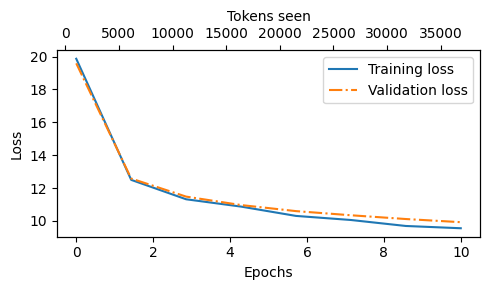

In [70]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#A 创建与 y 轴共用的第二个 x 轴
#B 用于对齐刻度的隐藏图形

In [71]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")


tok_emb.weight: torch.Size([50257, 768])
pos_emb.weight: torch.Size([256, 768])
trf_blocks.0.att.queries.weight: torch.Size([768, 768])
trf_blocks.0.att.keys.weight: torch.Size([768, 768])
trf_blocks.0.att.values.weight: torch.Size([768, 768])
trf_blocks.0.att.proj.weight: torch.Size([768, 768])
trf_blocks.0.att.proj.bias: torch.Size([768])
trf_blocks.0.ff.layers.0.0.weight: torch.Size([3072, 768])
trf_blocks.0.ff.layers.0.0.bias: torch.Size([3072])
trf_blocks.0.ff.layers.2.0.weight: torch.Size([768, 3072])
trf_blocks.0.ff.layers.2.0.bias: torch.Size([768])
trf_blocks.1.att.queries.weight: torch.Size([768, 768])
trf_blocks.1.att.keys.weight: torch.Size([768, 768])
trf_blocks.1.att.values.weight: torch.Size([768, 768])
trf_blocks.1.att.proj.weight: torch.Size([768, 768])
trf_blocks.1.att.proj.bias: torch.Size([768])
trf_blocks.1.ff.layers.0.0.weight: torch.Size([3072, 768])
trf_blocks.1.ff.layers.0.0.bias: torch.Size([3072])
trf_blocks.1.ff.layers.2.0.weight: torch.Size([768, 3072])
trf

## 5.3 通过解码策略控制生成结果的随机性

In [72]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you, GohanYes--,, Gohan--,,,, I,--,,,,,, Gohan Gohan--,


In [73]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
# argmax 返回最大值位置的張量
# .item() 用于把只包含一个数值的张量（tensor）转换为普通的 Python 数值类型
# （比如 int 或 float）。
print(inverse_vocab[next_token_id])

forward


In [74]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [75]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


采样只能选取大于0的数

torch.multinomial(input, num_samples, replacement=False, *, generator=None, out=None)

input: 一维/二维 tensor，每个元素是权重（可不是概率，但都应≥0，不能全为0）。

num_samples: 采样个数。

replacement: 是否有放回采样（默认False）。True时每次都可被选，False时每次选中后不能再次被选。

返回值：shape为 [num_samples] 的 LongTensor，元素是下标。

import torch
weights = torch.tensor([0.1, 0.2, 0.7])
samples = torch.multinomial(weights, 5, replacement=True)
print(samples)
结果可能是：tensor([2, 1, 2, 2, 0])

2 被选中的概率最大（0.7），所以很可能多次被选中。


torch.bincount(arr)：统计一维整数 tensor 每个可能取值的出现次数（频率）。

输入如 [2, 1, 2, 2, 0, 1]

返回 [1, 2, 3]

0出现1次，1出现2次，2出现3次。

和 numpy.bincount 类似，是高效计数统计工具（只能用于非负整数）

In [76]:
logits,logits.shape

(tensor([[[  7.0587,  -3.2935, -13.1793,  ...,   2.9044,   3.7385,   8.4152],
          [  4.0956,  -5.2586, -13.6300,  ...,   2.8654,   3.5133,   8.8506],
          [  5.3851,  -6.1039, -11.4961,  ...,   3.3582,   5.0339,   7.4872]],
 
         [[  3.5163,  -0.4896, -11.9791,  ...,  -0.7037,   6.5363,   9.6311],
          [  5.1303,  -0.9495, -12.8363,  ...,   1.1346,   6.3823,   8.0247],
          [  6.9907,  -0.9637,  -9.4921,  ...,  -0.7716,   7.9530,   7.7548]]]),
 torch.Size([2, 3, 50257]))

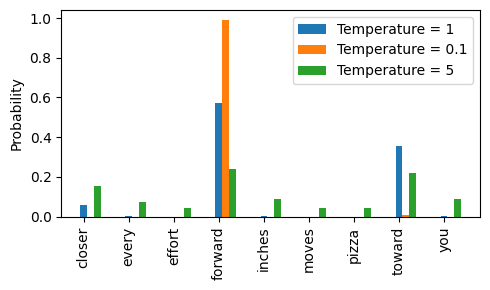

In [77]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)
#Temperatures greater than 1 result in more uniformly distributed token probabilities, and Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions. Let's illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:
temperatures = [1, 0.1, 5]             #A
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#A 原始、较低和较高置信度

# 其中 temperature 默认为 1。
# temperature < 1：分母变小，softmax 更“激进”，
# 概率分布更加尖锐，最大概率的 token 更容易被选中（更“自信”）。
# temperature > 1：分母变大，softmax 更“温和”，
# 概率分布更平缓，各 token 被采样的概率差距缩小，生成内容更加多样、更加“随机”。
## 较高的 temperature 值会使下一词的概率分布更均匀，
# 从而降低模型反复选择最可能词的概率，这样可以生成更多样化的内容

在 top-k 采样中，我们可以将采样限制在最有可能的前 k 个 token 内，并通过将其他 token 的概率设为零，将它们排除在选择之外

In [78]:
top_k = 3
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [79]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],   #A
    input=torch.tensor(float('-inf'),device = next_token_logits.device),              #B
    other=next_token_logits                         #C
)# 如果A成立，那么就是input，否则就是other
print(new_logits)

#A 识别出小于 top 3 最小值的 logits
#B 将这些较小的 logits 赋值为负无穷大
#C 保留所有其他 token 的原始 logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [80]:
topk_probas = torch.softmax(new_logits,dim=0)
topk_probas

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

### 5.3.3 对文本生成函数进行调整

In [81]:
# Listing 5.4 A modified text generation function with more diversity
def generate(model, idx, max_new_tokens, context_size,
             temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):                             #A
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:                                   #B
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:                                       #C
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:                                                       #D
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:                                      #E
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


#A For循环与之前相同：获取logits，仅关注最后的时间步
#B 在新步骤中，通过top-k采样过滤logits
#C 在新步骤中应用temperature scaling
#D 在未使用temperature scaling时，执行贪婪的下一个token选择
#E 如果遇到序列结束token且指定了eos_id，则提前停止生成

In [82]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you, the a browserACK, a Iretchedestonesra, Gohan Gohan.


In [83]:
torch.save(model.state_dict(),"model.pth")

In [84]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()
#dropout 通过在训练过程中随机“丢弃”某些神经元，以防止模型过拟合。
# 然而，在推理阶段，我们不希望随机丢弃网络中学到的任何信息。
# 通过使用 model.eval()，模型会切换到推理阶段的评估模式，从而禁用 dropout 层。

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (queries): Linear(in_features=768, out_features=768, bias=False)
        (keys): Linear(in_features=768, out_features=768, bias=False)
        (values): Linear(in_features=768, out_features=768, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
          )
          (1): GELU()
          (2): Sequential(
            (0): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shotcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBl

In [86]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [87]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (queries): Linear(in_features=768, out_features=768, bias=False)
        (keys): Linear(in_features=768, out_features=768, bias=False)
        (values): Linear(in_features=768, out_features=768, bias=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
          )
          (1): GELU()
          (2): Sequential(
            (0): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shotcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBl

In [88]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x20548a71450>)

In [89]:
from gpt_download import download_and_load_gpt2 
settings, params = download_and_load_gpt2( model_size="124M", models_dir="gpt2" )

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 77.0kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.33MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 90.0kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:05<00:00, 3.98MiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.07MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 737kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 702kiB/s] 


In [90]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


2. Parameter dictionary keys（模型权重参数dict中的主键）
'blocks'：Transformer主干的每一层（block）的参数集合。
GPT-2 结构是 N 层 transformer block 堆叠，blocks 保存了每层的注意力、MLP等权重。

'b'、'g'（有些实现用 'ln_f'）：最终LayerNorm（归一化层）的参数

'b' 可能指 layer norm 的 bias（偏置）

'g' 可能指 layer norm 的 gain（缩放/scale）

这两项常用于最后一层输出归一化（final layernorm）

'wpe'：位置编码参数（word positional embedding）

shape=[n_ctx, n_embd]

每个位置一个向量，用于捕获 token 的序列顺序信息

'wte'：词嵌入参数（word token embedding）

shape=[n_vocab, n_embd]

每个 token id 对应一个 embedding 向量，是输入 token id → 向量的“字典”

In [91]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [ ]:
# First, we create a dictionary that lists the differences between the different GPT model sizes, as explained in Figure 5.17:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use the corresponding settings from the model_configs table able to update our full-length GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
print(NEW_CONFIG)
NEW_CONFIG.update(model_configs[model_name])
# 如果 key 已存在，用新值覆盖/替换原有值。
# 如果 key 不存在，就把新 key/value 直接加进来。
# 不影响原来的 dict，只在拷贝后的 NEW_CONFIG 上生效。

{'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [94]:
NEW_CONFIG.update({"context_length": 1024})

In [97]:
NEW_CONFIG.update({"qkv_bias": True})
# We can now use the updated NEW_CONFIG dictionary to initialize a new GPTModel instance:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (queries): Linear(in_features=768, out_features=768, bias=True)
        (keys): Linear(in_features=768, out_features=768, bias=True)
        (values): Linear(in_features=768, out_features=768, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
          )
          (1): GELU()
          (2): Sequential(
            (0): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shotcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBloc

In [98]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [99]:
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享

In [100]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

AttributeError: 'MultiHeadAttention' object has no attribute 'W_query'